In [258]:
import math
from scipy import signal
from PIL import Image
import numpy
from numpy import *
from matplotlib import pyplot as plt
from pylab import *
import cv2
import random
from ipynb.fs.full.LK_Multi_Channel import *
from src.representation.colorwhele import visualize_flow
from src.evaluation.end_point_error import calc_MEPE_directory
from src.evaluation.angular_error import calc_AAE_directory

In [259]:
'''
In regular optical flow method, we assume the following:
	a) brightness constancy
	b) small motion
	c) Spatial coherence
Now, if the object were to move a larger distance then the traditional
optical flow method would work bad. This is why, we use gaussian pyramids
(coarse-to-fine) method to apply optical flow.

Pyramid is built by using multiple copies of the same image.
Each level in the pyramid is 1//4th of the size of the previous level and when stacked together
it looks like a pyramid. The lowest level is of the highest resolution and the highest level
is of the lowest resolution.

Algorithm for downsamples (to produce I[m//2,n//2](i+1) layer for I[m,n](i):
	a) Convolve I(i) with the Gaussian kernel, G.
	b) Remove every even numbered row and column			#up-sample by a factor of 2
	This follows that each image (I(i+1)next layer) is exactly one-quarter the area of its predecessor (I(i) current frame).

Algorithm for upsamples (to produce I[2m, 2n](i+1) layer for I[m,n](i)):
	a) Insert zero column and row alternatively. This ensure the I[2m, 2n]
	b) Convolve I[2m, 2n] with G of double the size to be used.

Optical Flow is implemeneted in the same as described in the previous program

We need to use the result of current iteration to be propagated to the next iteration and thats why we define the next function,
which calculates the optical flow in a same sized window.

Finally we write a function which combines all the above user-defined functions to include the Lucas Kanade algorithm iteratively over all the levels

'''

'\nIn regular optical flow method, we assume the following:\n\ta) brightness constancy\n\tb) small motion\n\tc) Spatial coherence\nNow, if the object were to move a larger distance then the traditional\noptical flow method would work bad. This is why, we use gaussian pyramids\n(coarse-to-fine) method to apply optical flow.\n\nPyramid is built by using multiple copies of the same image.\nEach level in the pyramid is 1//4th of the size of the previous level and when stacked together\nit looks like a pyramid. The lowest level is of the highest resolution and the highest level\nis of the lowest resolution.\n\nAlgorithm for downsamples (to produce I[m//2,n//2](i+1) layer for I[m,n](i):\n\ta) Convolve I(i) with the Gaussian kernel, G.\n\tb) Remove every even numbered row and column\t\t\t#up-sample by a factor of 2\n\tThis follows that each image (I(i+1)next layer) is exactly one-quarter the area of its predecessor (I(i) current frame).\n\nAlgorithm for upsamples (to produce I, 2n](i+1) layer

In [260]:
def gmask (x,y,s): # the function for gaussian filter
    gmask = numpy.exp(-((x**2) + (y**2))//2//s**2)
    return gmask

size  = 2
#Utilize the standard deviation from the paper.
t = 0.5
s = sigma = math.sqrt(2/(4*t))
G = [] # Gaussian Kernel
for i in range(-size,size+1):
    G.append(gmask(i,0,s)) # equating y to 0 since we need a 1D matrix

In [261]:
G

[0.1353352832366127,
 0.36787944117144233,
 1.0,
 0.36787944117144233,
 0.1353352832366127]

In [273]:
def DoLow (I): # the function down samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Apply x mask
           2) Delete Alternate Columns
           3) Apply y mask
           4) delete alternate rows
           The ouput image is of size (r//2)x(c//2)'''
   
    tau = 0.5
    sigma = math.sqrt(2/(4*tau))
    I = cv2.GaussianBlur(I,(5,5),sigma)
    
    # Resize
    
    width = int(I.shape[1]  /2 )
    height = int(I.shape[0] /2)
    dim = (width, height)
  
    # resize image
    I_resized = cv2.resize(I, dim, interpolation = cv2.INTER_CUBIC)
 
    print(I_resized.shape)
    plt.imshow(I_resized)
    plt.show()

    return I_resized


In [ ]:
def DoLow (I): # the function down samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Apply x mask
           2) Delete Alternate Columns
           3) Apply y mask
           4) delete alternate rows
           The ouput image is of size (r//2)x(c//2)'''
    #========= Applying X mask ====================

    Ix = []
    for i in range(len(I[:,0])):
        Ix.extend([signal.convolve(I[i,:,0],G,'same')]) # Ix*Gx = Ix
        Ix.extend([signal.convolve(I[i,:,1],G,'same')]) # Ix*Gx = Ix
        Ix.extend([signal.convolve(I[i,:,2],G,'same')]) # Ix*Gx = Ix

    Ix = array(matrix(Ix))

    #========selecting alternate columns===========
    Ix = I
    Ix = Ix[:,::2,:]
    #========= Applying Y mask ====================

    Ixy = []
    for i in range(len(Ix[0,:])):
        Ixy.extend([signal.convolve(Ix[:,i,0],G,'same')]) # Ix * Gy = Ixy
        Ixy.extend([signal.convolve(Ix[:,i,1],G,'same')]) # Ix * Gy = Ixy
        Ixy.extend([signal.convolve(Ix[:,i,2],G,'same')]) # Ix * Gy = Ixy
    Ixy = array(matrix(transpose(Ixy)))

    print(Ixy.shape)
    #========selecting alternate rows===========

    Ixy = Ixy[::2,:,:]
    return Ixy


In [179]:
def DoLow (I): # the function down samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Apply x mask
           2) Delete Alternate Columns
           3) Apply y mask
           4) delete alternate rows
           The ouput image is of size (r//2)x(c//2)'''
    #========= Applying X mask ====================

    Ix = []
    for i in range(len(I[:,0])):
        Ix.extend([signal.convolve(I[i,:,0],G,'same')]) # Ix*Gx = Ix
        Ix.extend([signal.convolve(I[i,:,1],G,'same')]) # Ix*Gx = Ix
        Ix.extend([signal.convolve(I[i,:,2],G,'same')]) # Ix*Gx = Ix

    Ix = array(matrix(Ix))

    #========selecting alternate columns===========
    Ix = I
    Ix = Ix[:,::2,:]
    #========= Applying Y mask ====================

    Ixy = []
    for i in range(len(Ix[0,:])):
        Ixy.extend([signal.convolve(Ix[:,i,0],G,'same')]) # Ix * Gy = Ixy
        Ixy.extend([signal.convolve(Ix[:,i,1],G,'same')]) # Ix * Gy = Ixy
        Ixy.extend([signal.convolve(Ix[:,i,2],G,'same')]) # Ix * Gy = Ixy
    Ixy = array(matrix(transpose(Ixy)))

    print(Ixy.shape)
    #========selecting alternate rows===========

    Ixy = Ixy[::2,:,:]
    return Ixy

In [263]:
def DoHigh (I,G): # the function up samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Insert zero column on every alternate columns
           2) Apply x mask
           3) Insert zero row on every alternate rows
           4) Apply y mask
           The ouput image is of size (2r)x(2c)'''
    G = numpy.dot(2,G) # Doubing the Guassian kernel since we later use alternate rows and columns
    #=========== Inserting alternate columns of zeros ========
    newI = numpy.zeros(shape=(shape(I)[0],2*shape(I)[1]))
    newI[:, ::2] = I
    #========= Applying X mask ====================

    Ix = []
    for i in range(len(newI[:,0])):
        Ix.extend([signal.convolve(newI[i,:],G,'same')]) # newI*G ----> x direction
        #Ix.extend([signal.convolve(newI[i,:,1],G,'same')]) # newI*G ----> x direction
        #Ix.extend([signal.convolve(newI[i,:,2],G,'same')]) # newI*G ----> x direction
    Ix = array(matrix(Ix))

    #=========== Inserting alternate rows of zeros ========
    #Ix = newI
    newI = numpy.zeros(shape=(2*shape(Ix)[0],shape(Ix)[1]))
    newI[::2] = Ix
    #========= Applying Y mask ====================
    Ixy = newI

    Ixy = []
    for i in range(len(newI[0,:])):
        Ixy.extend([signal.convolve(newI[:,i],G,'same')]) # Ixy
        #Ixy.extend([signal.convolve(newI[:,i,1],G,'same')]) # Ixy
        #Ixy.extend([signal.convolve(newI[:,i,2],G,'same')]) # Ixy
    Ixy = array(matrix(transpose(Ixy)))
    print(Ixy.shape)
    return Ixy # Return Ixy...

In [264]:
def calcDerivativesForEachChannel(img):
    red = img[:,:,2]
    green = img[:,:,1]
    blue = img[:,:,0]

    #Calculate X derivatives
    I0x = cv2.Sobel(blue,cv2.CV_64F,1,0, ksize=3)
    I1x = cv2.Sobel(green,cv2.CV_64F,1,0, ksize=3)
    I2x = cv2.Sobel(red,cv2.CV_64F,1,0, ksize=3)

    #Caluclate Y derivatives
    I0y = cv2.Sobel(blue,cv2.CV_64F,0,1, ksize=3)
    I1y = cv2.Sobel(green,cv2.CV_64F,0,1, ksize=3)
    I2y = cv2.Sobel(red,cv2.CV_64F,0,1, ksize=3)

    return I0x,I1x,I2x,I0y,I1y,I2y

In [265]:
def lk1_multi(prevImg, nextImg, winSize = 39, threshD = 1e-9):
    prevImg = prevImg/1.
    nextImg = nextImg/1.

    #PrevImgBlue,PrevImgGreen,PrevImgrRed = extractChannels(prevImg)
    #NextImgBlue,NextImgGreen,NextImgrRed = extractChannels(prevImg)

    #Calculate derivatives alond x and y

    prevI0x,prevI1x,prevI2x,prevI0y,prevI1y,prevI2y = calcDerivativesForEachChannel(prevImg)
    nextI0x,nextI1x,nextI2x,nextI0y,nextI1y,nextI2y = calcDerivativesForEachChannel(nextImg)


    #compromise solution by the least squares principle

    sigma1 = prevI0x**2 + prevI1x**2 + prevI2x**2+ nextI0x**2 +nextI1x**2 +nextI2x**2

    sigma2 = sigma4 = prevI0x* prevI0y + prevI1x* prevI1y + prevI2x* prevI2y + nextI0x* nextI0y + nextI1x* nextI1y + nextI2x* nextI2y

    sigma3 = (nextImg[:,:,0]-prevImg[:,:,0])*(prevI0x + nextI0x) + (nextImg[:,:,1]-prevImg[:,:,1])*(prevI1x + nextI1x)+ (nextImg[:,:,2]-prevImg[:,:,2])*(prevI2x + nextI2x)

    sigma5 = prevI0y**2 + prevI1y**2 + prevI2y**2+ nextI0y**2 +nextI1y**2 +nextI2y**2

    sigma6 = (nextImg[:,:,0]-prevImg[:,:,0])*(prevI0y + nextI0y) + (nextImg[:,:,1]-prevImg[:,:,1])*(prevI1y + nextI1y)+ (nextImg[:,:,2]-prevImg[:,:,2])*(prevI2y + nextI2y)

    sigma = [sigma1, sigma2, sigma3, sigma4, sigma5, sigma6]

    for i in range(len(sigma)):
        #apply average blurring
        #sigma[i] = cv2.blur(sigma[i], (winSize, winSize))
        #Gaussian blurring. The sigma determines the contribution of neighbours.
        sigma[i] = cv2.GaussianBlur(sigma[i],(winSize, winSize),0)

    #Use Cramer's rule to solve the equation

    #Calculate determinant of the coefficients
    D = sigma[1]**2 - sigma[0]*sigma[4]
    D[np.abs(D) < threshD] = np.Inf


    #Cramers rule
    # https://pressbooks.bccampus.ca/algebraintermediate/chapter/solve-systems-of-equations-using-determinants/
    # Replace the X coefficients with the constants and take the determinant
    hx = (sigma[4]*sigma[2]-sigma[1]*sigma[5]) / D
    # Replace the Y coefficients with the constants and take the determinant
    hy = (sigma[1]*sigma[2]-sigma[0]*sigma[5]) / D


    return hx, -hy

In [274]:
def lksection (I1 # frame 1
               ,I2 # frame 2
               ,uin # u from previous level
               ,vin # v from previous level
               ):
    '''This function runs the LK Algorithm for the current section of pyramid iteratively.
    We take a window of 5x5 and move from left top corner to right bottom corner in order to calculate the vectors for that window.
    Once the whole image is done, we sum the vectors of current and previous levels.
    '''

    uin = numpy.round(uin)
    vin = numpy.round(vin)
    u = numpy.zeros([len(I1[:,0]),len(I1[0,:])])
    v = numpy.zeros([len(I2[:,0]),len(I2[0,:])])


    for i in range (2,len(I1[:,0])-2):
        for j in range (2,len(I2[0,:])-2):
            I1current = I1[i-2:i+3,j-2:j+3] # picking 5x5 pixels at a time
            lri = (i-2)+vin[i,j] #Low Row Index of the selected window
            hri = (i+2)+vin[i,j] #High Row Index of the selected window
            lci = (j-2)+uin[i,j] #Low Column Index of the selected window
            hci = (j+2)+uin[i,j] #High Column Index of the selected window

            #============= 5 x 5 Window search ===============
            '''
            When the 5x5 window goes beyond the resolution of the concerned image
            we choose the ending 5x5 window for that image.
            '''

            if(lri < 0): # if the window goes towards the left of the image
                lri = 0
                hri = 4
            if(lci < 0): # if the window goes above the image
                lci = 0
                hci = 4
            if(hri > (len(I1[:,0]))-1): #if the window goes towards the right of the image
                lri = len(I1[:,0])-5
                hri = len(I1[:,0])-1
            if(hci > (len(I1[0,:]))-1): # if the window goes below the image
                lci = len(I1[0,:])-5
                hci = len(I1[0,:])-1
            if(numpy.isnan(lri)):
                lri = i-2
                hri = i+2
            if(numpy.isnan(lci)):
                lci = j-2
                hci = j+2

            hci = int(hci)
            hri = int(hri)
            lci = int(lci)
            lri = int(lri)

            #Selecting the same window for the second frame

            I2current = I2[lri:(hri+1),lci:(hci+1)]

            # Now applying LK for each window of the 2 images
            I1current = I1current/1.
            I2current = I2current/1.

            prevI0x,prevI1x,prevI2x,prevI0y,prevI1y,prevI2y = calcDerivativesForEachChannel(I1current)
            nextI0x,nextI1x,nextI2x,nextI0y,nextI1y,nextI2y = calcDerivativesForEachChannel(I2current)


            #compromise solution by the least squares principle

            sigma1 = prevI0x**2 + prevI1x**2 + prevI2x**2+ nextI0x**2 +nextI1x**2 +nextI2x**2

            sigma2 = sigma4 = prevI0x* prevI0y + prevI1x* prevI1y + prevI2x* prevI2y + nextI0x* nextI0y + nextI1x* nextI1y + nextI2x* nextI2y

            sigma3 = (I2current[:,:,0]-I1current[:,:,0])*(prevI0x + nextI0x) + (I2current[:,:,1]-I1current[:,:,1])*(prevI1x + nextI1x)+ (I2current[:,:,2]-I1current[:,:,2])*(prevI2x + nextI2x)

            sigma5 = prevI0y**2 + prevI1y**2 + prevI2y**2+ nextI0y**2 +nextI1y**2 +nextI2y**2

            sigma6 = (I2current[:,:,0]-I1current[:,:,0])*(prevI0y + nextI0y) + (I2current[:,:,1]-I1current[:,:,1])*(prevI1y + nextI1y)+ (I2current[:,:,2]-I1current[:,:,2])*(prevI2y + nextI2y)

            sigma = [sigma1, sigma2, sigma3, sigma4, sigma5, sigma6]

            for g in range(len(sigma)):
                #apply average blurring
                #sigma[i] = cv2.blur(sigma[i], (winSize, winSize))
                #Gaussian blurring. The sigma determines the contribution of neighbours.
                sigma[g] = cv2.GaussianBlur(sigma[g],(5, 5),0)

            #Use Cramer's rule to solve the equation

            #Calculate determinant of the coefficients
            D = sigma[1]**2 - sigma[0]*sigma[4]
            D[np.abs(D) < 1e-9] = np.Inf


            #Cramers rule
            # https://pressbooks.bccampus.ca/algebraintermediate/chapter/solve-systems-of-equations-using-determinants/
            # Replace the X coefficients with the constants and take the determinant
            hx = (sigma[4]*sigma[2]-sigma[1]*sigma[5]) / D
            # Replace the Y coefficients with the constants and take the determinant
            hy = (sigma[1]*sigma[2]-sigma[0]*sigma[5]) / D

            #TODO: TRY MEDIAN FILTER
            u[i,j] = hx[2,2]
            v[i,j] = -hy[2,2]


    u = u+uin
    v = v+vin

    return u,v

In [275]:
def runproglk (I1,
               I2,
               iternum, # Number of iterations per level -- we are using 3
               nlev # Number of levels -- we are using 3
               ):

    I1 = cv2.imread(I1)
    I2= cv2.imread(I2)
    I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
    I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)
    ''' The function uses all the above defined function to implement LK algorithm in a multi-resolution Gaussian pyramid
    framework. We use the following :
    window size of 3x3
    Pyramid size = 3 levels
    Starting from the lower most level, at each level we use the iterative LK algorithm and then warp and upsample it so that it can be used for the next level.
    '''
    p1=numpy.empty((len(I1[:,0]),len(I1[0,:]),3,nlev)) # creating 4d array with different levels for frame 1
    p2=numpy.empty((len(I2[:,0]),len(I2[0,:]),3,nlev)) # creating 4d array with different levels for frame 2
    p1[:,:,:,0] = I1 # assign values for Highest level
    p2[:,:,:,0] = I2 # assign values for Highest level
    '''
    p[:,:,0] ---> Level 2 ---> Highest resolution
    p[:,:,2] ---> Level 0 ---> Least resolution
    '''
    # Defining the lower levels
    for i in range(1,nlev):
        I1 = DoLow(I1)
        I2 = DoLow(I2)
        p1[0:int((len(I1[:,0]))),0:int((len(I1[0,:]))),:,i] = I1
        p2[0:int((len(I2[:,0]))),0:int((len(I2[0,:]))),:,i] = I2

    #===================== level 0 - Base====================

    l0I1 = p1[0:int((len(p1[:,0])//4)),0:int((len(p1[0,:])//4)),:,2]
    l0I2 = p2[0:int((len(p2[:,0])//4)),0:int((len(p2[0,:])//4)),:,2]
    (u,v)= lk1_multi(I1,I2)
    #============= Iterative LK for that section============

    for j in range(1,iternum+1):
        (u,v) = lksection (l0I1,l0I2,u,v)
    #============= Store U and V values ===================

    ul0 = u
    vl0 = v
    Il0 = l0I1
    ul0[numpy.where(ul0 == 0)] = nan
    vl0[numpy.where(vl0 == 0)] = nan
    #====================Level 1===================
    k = 1
    ue = DoHigh (u,G)
    ve = DoHigh (v,G)
    I1current = p1[0:(len(p1[:,0])//(2**(nlev-k-1))),0:(len(p1[0,:])//(2**(nlev-k-1))),:,nlev-k-1]
    I2current = p2[0:(len(p2[:,0])//(2**(nlev-k-1))),0:(len(p2[0,:])//(2**(nlev-k-1))),:,nlev-k-1]
    (u,v) = lksection (I1current,I2current,ue,ve)

    #========== Iterative LK for that section ===========
    for l in range(1,iternum+1):
        (u,v) = lksection (I1current,I2current,ue,ve)

    #============= Store U and V values ===================
    ul1 = u
    vl1 = v
    Il1 = I1current
    ul1[numpy.where(ul1 == 0)] = nan
    vl1[numpy.where(vl1 == 0)] = nan
    #====================Level 2=========================
    k = 2
    ue = DoHigh (u,G)
    ve = DoHigh (v,G)
    I1current = p1[0:(len(p1[:,0])//(2**(nlev-k-1))),0:(len(p1[0,:])//(2**(nlev-k-1))),:,nlev-k-1]
    I2current = p2[0:(len(p2[:,0])//(2**(nlev-k-1))),0:(len(p2[0,:])//(2**(nlev-k-1))),:,nlev-k-1]
    (u,v) = lksection (I1current,I2current,ue,ve)
    #========== Iterative LK for that section ===========
    for l in range(1,iternum+1):
        (u,v) = lksection (I1current,I2current,ue,ve)
    #============= Store U and V values ===================
    ul2 = u
    vl2 = v
    Il2 = I1current

    return(ul0,vl0,Il0,ul1,vl1,Il1,ul2,vl2,Il2)

In [276]:
def calc_all_flow():
    folders = ["Dimetrodon","DogDance","Grove2","Grove3","Hydrangea","MiniCooper","RubberWhale","Urban2","Urban3","Venus","Walking"]
    for folder in folders:
        #prevImg= cv2.imread("dataset/other-data-color/"+folder+"/frame10.png")
        #nextImg= cv2.imread("dataset/other-data-color/"+folder+"/frame11.png")
        (ul01,vl01,Il01,ul11,vl11,Il11,ul21,vl21,Il21) = runproglk('dataset/other-data-color/'+folder+'/frame10.png','dataset/other-data-color/'+folder+'/frame11.png',3,3)
        print(folder +": Succesfully calcualted optical flow")
        out = visualize_flow(u = ul21, v = vl21)
        folder_out = 'results/result-other-color-LK/'+folder+'/'
        cv2.imwrite(folder_out+str(i)+'-MR+IR.png', out)

In [277]:
#calc_all_flow()

In [278]:
def calc():
    folders = ["Dimetrodon","Grove2","Grove3","Hydrangea","RubberWhale","Urban2","Urban3","Venus"]
    #folders = ["RubberWhale","Urban2","Urban3","Venus"]

    for folder in folders:
        #prevImg= cv2.imread("dataset/other-data-color/"+folder+"/frame10.png")
        #nextImg= cv2.imread("dataset/other-data-color/"+folder+"/frame11.png")
        (ul01,vl01,Il01,ul11,vl11,Il11,ul21,vl21,Il21) = runproglk('dataset/other-data-color/'+folder+'/frame10.png','dataset/other-data-color/'+folder+'/frame11.png',3,3)
        print(folder +": Succesfully calcualted optical flow")
        out = visualize_flow(u = ul21, v = vl21)
        #Save the flow image
        folder_out = "results/results-other-color-MR-IR/"+str(folder)+"/"
        if not os.path.exists(folder_out):
            os.mkdir(folder_out)
        cv2.imwrite(folder_out+ str(folder)+"-MR+IR-4.png", out)

        #Replace Nan's
        u = np.nan_to_num(ul21)
        v = np.nan_to_num(vl21)

        #Save the flow
        np.savetxt('results/results-other-color-pyramid-flow/'+folder+'-U.txt', u , fmt='%d')
        np.savetxt('results/results-other-color-pyramid-flow/'+folder+'-V.txt', v , fmt='%d')

        #Calculate statistics
        mepe, sdEpe = calc_MEPE_directory(folder, u = u, v = v)
        print("The Average End Point Error for "+folder+ " is: " + str(mepe)+" and the standard deviation is: "+str(sdEpe))

        mang, sdAngular = calc_AAE_directory(folder, u= u, v = v)

        print("The Average Angular error for "+folder+ " is: " + str(mang)+" and the standard deviation is: "+str(sdAngular))

In [279]:
# Both horizontal and vertical 
imgb = cv2.imread('dataset/other-data-color/'+'Venus'+'/frame10.png')
imgb = cv2.cvtColor(imgb, cv2.COLOR_BGR2RGB)
# plt.imshow(imga)

img_r = imgb[:,:,0]
img_g = imgb[:,:,1]
img_b = imgb[:,:,2]
# print(img_r.shape)
rows, cols = img_r.shape
print(imgb.dtype)
img_output_r = np.zeros((imgb.shape[0], imgb.shape[1]), dtype=imgb.dtype)
img_output_g = np.zeros((imgb.shape[0], imgb.shape[1]), dtype=imgb.dtype)
img_output_b = np.zeros((imgb.shape[0], imgb.shape[1]), dtype=imgb.dtype)
print(img_output_r)

for i in range(rows):
    for j in range(cols):
        offset_x = int(math.floor(u_x[i][j])) #int(20.0 * math.sin(2 * 3.14 * i / 150))
        offset_y = int(math.floor(v_y[i][j])) # int(20.0 * math.cos(2 * 3.14 * j / 150))
        if i-offset_y < rows and j-offset_x < cols:
            img_output_r[i,j] = img_r[(i-offset_y)%rows,(j-offset_x)%cols]
            img_output_g[i,j] = img_g[(i-offset_y)%rows,(j-offset_x)%cols]
            img_output_b[i,j] = img_b[(i-offset_y)%rows,(j-offset_x)%cols]

        else:
            img_output_r[i,j] = 0
            img_output_g[i,j] = 0
            img_output_b[i,j] = 0

img_output = np.dstack((img_output_r, img_output_g, img_output_b))
# print(img_output_r.shape)
# img_output = cv2.cvtColor(img_output, cv2.COLOR_GRAY2BGR)
plt.imshow(img_output)

uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


NameError: name 'u_x' is not defined

(194, 292, 3)


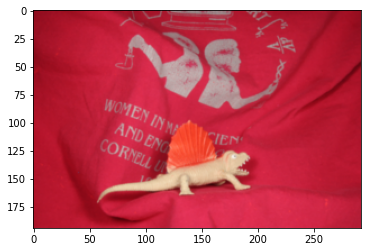

(194, 292, 3)


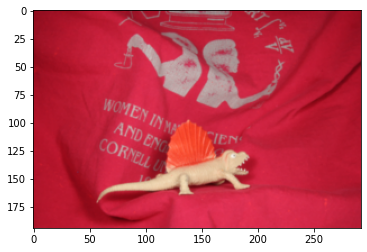

(97, 146, 3)


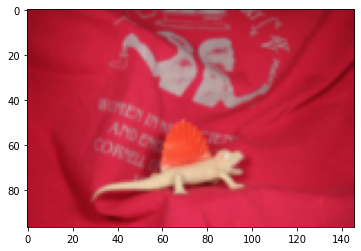

(97, 146, 3)


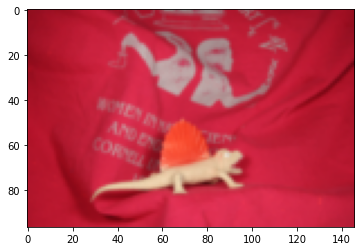

(194, 292)
(194, 292)
(388, 584)
(388, 584)
Dimetrodon: Succesfully calcualted optical flow
The Average End Point Error for Dimetrodon is: 1.66 and the standard deviation is: 0.72
The Average Angular error for Dimetrodon is: 0.66 and the standard deviation is: 0.22
(240, 320, 3)


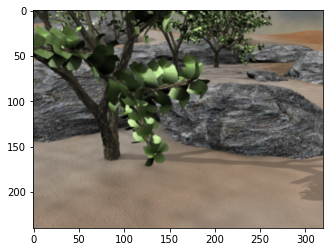

(240, 320, 3)


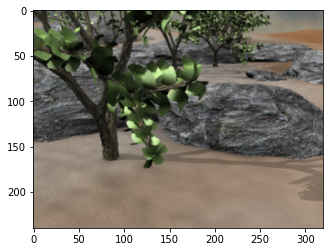

(120, 160, 3)


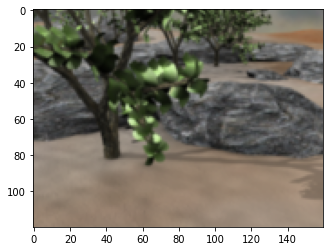

(120, 160, 3)


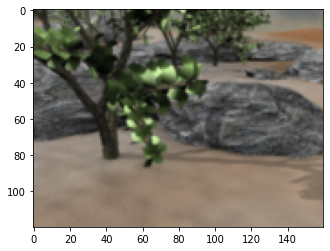

(240, 320)
(240, 320)


In [ ]:
calc() ######## SD OF professor